In [ ]:
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt

In [ ]:
# QR decomposition
def qr_decomposition(A):
    n, m = A.shape
    Q = np.zeros((n, m))
    R = np.zeros((m, m))
    for j in range(m):
        v = A[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], A[:, j])
            v = v - R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    return Q, R

In [ ]:
# apply qr decompoisiton iteratively to obtain eigenvalues and eigenvectors
def obtain_eig_by_qr(CtC, num_iter=1000, tol=1e-10):
    n = CtC.shape[0]
    Ak = CtC.copy()
    Q_total = np.eye(n)
    for _ in range(num_iter):
        Q, R = qr_decomposition(Ak)
        Ak = R @ Q  # @ is matrix multiplication
        Q_total = Q_total @ Q
        if np.allclose(Ak - np.diag(np.diag(Ak)), 0, atol=tol):
            break
    eigenvalues = np.diag(Ak)
    eigenvectors = Q_total
    idx = np.argsort(-np.abs(eigenvalues))
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    for i in range(eigenvectors.shape[1]):
        if eigenvectors[0, i] < 0:
            eigenvectors[:, i] *= -1
    return eigenvalues, eigenvectors

In [ ]:
# My SVD
def svd_2d(C):
    CtC = C.T @ C
    eigvals_V, V = obtain_eig_by_qr(CtC)
    singular_vals = np.sqrt(np.clip(eigvals_V, 0, None))
    U = np.zeros((C.shape[0], V.shape[1]))
    for i in range(len(singular_vals)):
        sigma = singular_vals[i]
        U[:, i] = (C @ V[:, i]) / sigma
    return U, singular_vals, V.T

In [ ]:
# Apply Kabsch Algorithm by computing R, t using correspondences
def kabsch(img1_pts, img2_pts):
    A_centroid = img1_pts.mean(axis=0)
    B_centroid = img2_pts.mean(axis=0)
    A_centered = img1_pts - A_centroid
    B_centered = img2_pts - B_centroid
    H = A_centered.T @ B_centered
    U, S, Vt = svd_2d(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = B_centroid - R @ A_centroid
    return R, t

In [ ]:
# merge images by using R, t matrices
def merge_images(img1, img2, R, t, save_path):
    h1, w1= img1.shape[:2]
    h2, w2= img2.shape[:2]

    coords= np.indices((h1, w1)).reshape(2, -1).T[:, ::-1]
    coords= coords.astype(np.float64)
    transformed_coords = (R @ coords.T).T + t

    all_coords=np.vstack((transformed_coords, [[x, y] for y in range(h2) for x in range(w2)]))
    min_xy=np.floor(all_coords.min(axis=0)).astype(int)
    max_xy = np.ceil(all_coords.max(axis=0)).astype(int)
    output_size = max_xy - min_xy
    offset = -min_xy

    merged = np.zeros((output_size[1], output_size[0], 3), dtype=np.uint8)

    # Paste img2
    for y in range(h2):
        for x in range(w2):
            new_x = x + offset[0]
            new_y = y + offset[1]
            if 0 <= new_x < merged.shape[1] and 0 <= new_y < merged.shape[0]:
                merged[new_y, new_x] = img2[y, x]

    # Paste transformed img1
    for i, (x_t, y_t) in enumerate(transformed_coords):
        orig_x, orig_y = coords[i]
        new_x = int(round(x_t + offset[0]))
        new_y = int(round(y_t + offset[1]))
        if (0 <= orig_x < w1 and 0 <= orig_y < h1 and
            0 <= new_x < merged.shape[1] and 0 <= new_y < merged.shape[0]):
            merged[new_y, new_x] = img1[int(orig_y), int(orig_x)]

    cv2.imwrite(save_path, merged)
    return save_path

def show_image(img1_path, img2_path, merged_path):
    # Load images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    merged = cv2.imread(merged_path)

    #Convert BGR to RGB
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    merged = cv2.cvtColor(merged, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Image 1")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Image 2")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    #Merged Image
    plt.figure(figsize=(6, 3))
    plt.imshow(merged)
    plt.title("Merged Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
#this prints R, t; merges images and plot images
def mergeImagesAndPlot(imageName):
    #load images
    img1= cv2.imread(f"{imageName}/image1.png")
    img2= cv2.imread(f"{imageName}/image2.png")

    with open(f"{imageName}/correspondences.json", "r") as f:
        correspondences = json.load(f)
    #get data from correspondences.json
    pts1= np.array([pair["img1_xy"] for pair in correspondences], dtype=np.float64)
    pts2= np.array([pair["img2_xy"] for pair in correspondences], dtype=np.float64)

    # apply kabsch-umayama algorithm and find R, t
    R, t =kabsch(pts1, pts2)
    print("Rotation Matrix R:", "\n", R)
    print("Translation Vector t:\n", t)
    merge_images(img1, img2, R, t, f"{imageName}/merged.png")
    show_image(f"{imageName}/image1.png", f"{imageName}/image2.png", f"{imageName}/merged.png")

Rotation Matrix R: 
 [[ 1.00000000e+00 -1.95692790e-17]
 [-4.57683808e-17  1.00000000e+00]]
Translation Vector t:
 [-2.08000000e+02 -7.67386155e-13]


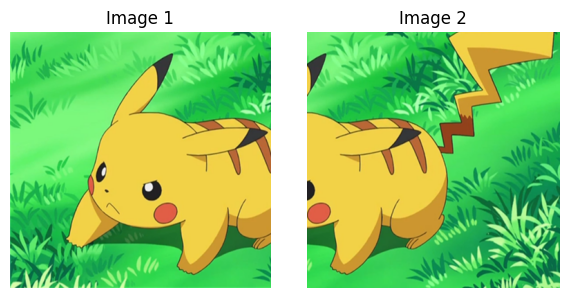

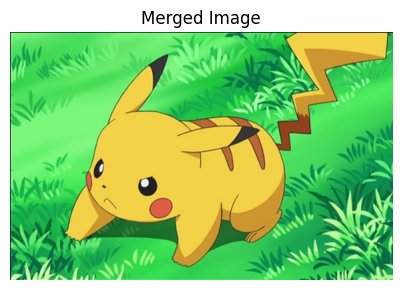

In [ ]:
#print R, t, merge images
mergeImagesAndPlot("pikachu")

Rotation Matrix R: 
 [[ 0.99727742  0.07374102]
 [-0.07374102  0.99727742]]
Translation Vector t:
 [-170.0771869    14.05095419]


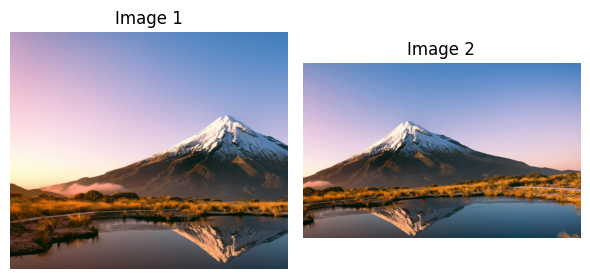

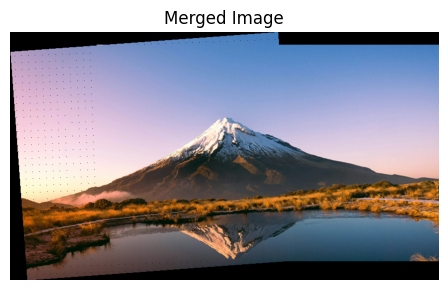

In [ ]:
mergeImagesAndPlot("mountain")

Rotation Matrix R: 
 [[ 0.67618151  0.73673507]
 [-0.73673507  0.67618151]]
Translation Vector t:
 [-227.89239158  247.94746728]


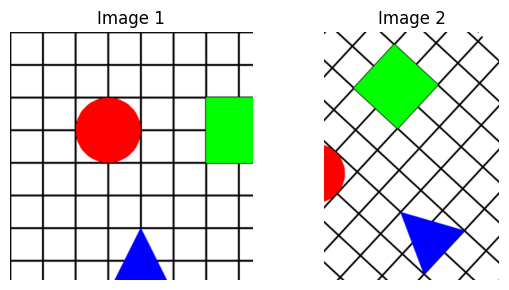

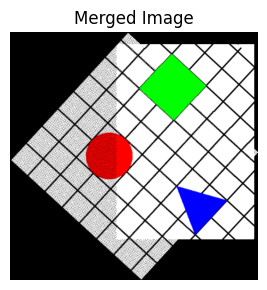

In [ ]:
mergeImagesAndPlot("grid")